# Import Libraries

In [478]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

In [479]:
import seaborn as sns
import matplotlib.pyplot as plt

In [480]:
from time import time
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import feature_selection
from sklearn.feature_selection import (
    RFE,
    SelectFromModel
)
from sklearn import linear_model
from sklearn.linear_model import (
    LogisticRegression,
    LassoCV
)
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier,
    ExtraTreesClassifier
)
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix,
    classification_report,
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score,
    fbeta_score
)
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.impute import KNNImputer
from sklearn.preprocessing import (
    StandardScaler,
    OrdinalEncoder, 
    LabelEncoder
)
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge


# Import Dataset

In [481]:
df = pd.read_csv('/Users/kritikanayyar/Documents/MMA/3 & 4. Complementary Courses Selection/7. Enterprise Data Science & Machine Learning in Production II/targeted_marketing/Dataset/bank-full.csv', delimiter=';')
#convert target variable to binary
df['y'] = df['y'].map({'yes': 1, 'no': 0})
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,1
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,0


In [482]:
# Calculate the total number of rows in the dataset
total_rows = len(df)

# List to store data for the new DataFrame
combined_summary = []

# Loop over each column to calculate unique values, their counts, and percentages
for column in df.columns:
    # Get value counts for the column
    counts = df[column].value_counts()
    # Calculate percentage of total for each category
    percentages = (counts / total_rows) * 100
    # Create a summary string that concatenates category with its percentage
    category_summary = ', '.join([f"{cat} ({perc:.2f}%)"
                                  for cat, perc in zip(counts.index, percentages)])
    # Get the number of unique values correctly
    unique_values = df[column].nunique()
    # Append unique count and category summary
    combined_summary.append([column, unique_values, category_summary])

# Create a DataFrame from the list
summary_df = pd.DataFrame(combined_summary, columns=['Column Name', 'Unique Values', 'Categories and Percentages'])

# Display the new DataFrame
summary_df

,Column Name,Unique Values,Categories and Percentages
0,age,77,"32 (4.61%), 31 (4.41%), 33 (4.36%), 34 (4.27%)..."
1,job,12,"blue-collar (21.53%), management (20.92%), tec..."
2,marital,3,"married (60.19%), single (28.29%), divorced (1..."
3,education,4,"secondary (51.32%), tertiary (29.42%), primary..."
4,default,2,"no (98.20%), yes (1.80%)"
5,balance,7168,"0 (7.77%), 1 (0.43%), 2 (0.35%), 4 (0.31%), 3 ..."
6,housing,2,"yes (55.58%), no (44.42%)"
7,loan,2,"no (83.98%), yes (16.02%)"
8,contact,3,"cellular (64.77%), unknown (28.80%), telephone..."
9,day,31,"20 (6.09%), 18 (5.10%), 21 (4.48%), 17 (4.29%)..."


# Data Pre-Proccessing

## Missing Data

In [483]:
def missing_values(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)
    print("Dataframe has " + str(df.shape[1]) + " columns.")
    print("There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    return mis_val_table_ren_columns

In [484]:
# Missing values statistics
miss_values = missing_values(df)
miss_values

Dataframe has 17 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


<div style="background-color: yellow; color: black; padding: 10px;">
    On the face, it looks there are no missing values. However, few columns include unknown and -1 values.
</div>

### Handle 'unknown' values in column 'job'

In [485]:
df['job'].value_counts()

job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64

**Iterative Imputer** primarily handles numerical data. **KNN Imputer** is also fundamentally numerical since K-NN involves calculating distances between datapoints, we must use numeric variables only.

#### Interpolation: Use a predictive model to predict the value of the missing data

In [486]:
# Split data into train and predict sets
train_df = df[df['job'] != 'unknown']
predict_df = df[df['job'] == 'unknown']

# Preprocess the data: Encode categorical variables with handle_unknown='ignore'
encoder = OneHotEncoder(handle_unknown='ignore')
X_train = encoder.fit_transform(train_df.drop('job', axis=1))
y_train = train_df['job']
X_predict = encoder.transform(predict_df.drop('job', axis=1))

# Create and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict the missing job values
job_predictions = model.predict(X_predict)

# Insert the predicted job values back into the original DataFrame
df.loc[df['job'] == 'unknown', 'job'] = job_predictions

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,admin.,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


### Handle 'unknown' values in column 'education'

In [487]:
df['education'].value_counts()

education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64

With ordinal data, the order of the categories carries important information and should be preserved in any encoding. Example, Ratings (e.g., poor, fair, good, very good, excellent). 

In [488]:
# Map 'education' to ordinal values and handle 'unknown' as NaN
education_map = {'primary': 1, 'secondary': 2, 'tertiary': 3, 'unknown': np.nan}
df['education_ordinal'] = df['education'].map(education_map)

In [489]:
# Setup the Iterative Imputer
imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=0)

# Impute missing values in the 'education_ordinal' column
df['education_ordinal_imputed'] = imputer.fit_transform(df[['education_ordinal']])

# Round the imputed values to the nearest integer
df['education_ordinal_imputed'] = np.round(df['education_ordinal_imputed'])

# Create a reverse map from ordinal numbers back to education labels
inverse_education_map = {v: k for k, v in education_map.items() if v is not None}

# Correct the mapping: Use 'education_ordinal_imputed' to update 'education'
df['education'] = df['education_ordinal_imputed'].map(inverse_education_map)

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,education_ordinal,education_ordinal_imputed
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0,3.0,3.0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0,2.0,2.0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0,2.0,2.0
3,47,blue-collar,married,secondary,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0,NaN,2.0
4,33,admin.,single,secondary,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0,NaN,2.0


### Handle 'unknown' values in column 'contact'

In [490]:
df['contact'].value_counts()

contact
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64

<div style="background-color: yellow; color: black; padding: 10px;">
    'contact' represents contact communication type. Since there is no way of finding the substitute for unknown values, we will remove column 'contact'.
</div>

In [491]:
# Remove 'contact' column
df.drop('contact', axis=1, inplace=True)

### Handle -1 values in column 'pdays'

In [492]:
df['pdays'].value_counts()

pdays
-1      36954
 182      167
 92       147
 91       126
 183      126
        ...  
 449        1
 452        1
 648        1
 595        1
 530        1
Name: count, Length: 559, dtype: int64

<div style="background-color: yellow; color: black; padding: 10px;">
    -1 means client was not previously contacted.
</div>

### Handle 'unknown' values in column 'poutcome'

In [493]:
df['poutcome'].value_counts()

poutcome
unknown    36959
failure     4901
other       1840
success     1511
Name: count, dtype: int64

<div style="background-color: yellow; color: black; padding: 10px;">
    Cases where client was not previously contacted (pdays equals -1), outcome of the previous marketing campaign is bound to be unknown.
</div>

#### Remove rows where client was previously contacted and the outcome is unknown.

In [494]:
# Removing rows where the client was previously contacted (pdays > 0) and the outcome is unknown
df = df[~((df['pdays'] > 0) & (df['poutcome'] == 'unknown'))]
df.shape

(45206, 18)

In [495]:
# Drop 'education', 'education_ordinal', 'education_ordinal_imputed' columns
df.drop(['education_ordinal', 'education_ordinal_imputed'], axis=1, inplace=True)

# Dealing with categorical features
Choosing the right type of encoding for categorical variables depends on several factors, including the number of unique values in the column (cardinality), the nature of the categories (ordinal vs nominal). 
- With ordinal data, the order of the categories carries important information and should be preserved in any encoding. Example, Ratings (e.g., poor, fair, good, very good, excellent). 
- Nominal data (also known as categorical data) refers to categories that do not have any intrinsic ordering. The categories are distinct and there's no relationship or hierarchy among them. Common examples include: Colors (e.g., red, blue, green), Gender (e.g., male, female, non-binary)

In [496]:
df.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,secondary,no,1506,yes,no,5,may,92,1,-1,0,unknown,0
4,33,admin.,single,secondary,no,1,no,no,5,may,198,1,-1,0,unknown,0


### One-hot Encoding
Nominal data: marital, poutcome

In [497]:
# Apply one-hot encoding to specified columns
df_encoded = pd.get_dummies(df, columns=['marital', 'poutcome'])

### Binary Encoding

In [498]:
df_encoded[['default', 'housing', 'loan']] = df_encoded[['default', 'housing', 'loan']].apply(lambda x: x.map({'yes': 1, 'no': 0}))

### Label Encoding
Nominal data with high cardinality: month

In [499]:
# Instantiate the LabelEncoder
encoder = LabelEncoder()

# Apply LabelEncoder to multiple columns
df_encoded['month'] = encoder.fit_transform(df_encoded['month'])
df_encoded['job'] = encoder.fit_transform(df_encoded['job'])

### Ordinal Encoding
Ordinal data: education

In [500]:
# Define the mapping from category to integer
education_mapping = {
    'primary': 1,
    'secondary': 2,
    'tertiary': 3
}

# Apply the mapping to the 'education' column
df_encoded['education'] = df_encoded['education'].map(education_mapping)

### Final Encoded Data

In [501]:
df_encoded.shape

(45206, 21)

# Feature Selection
Drop the attributes that provide no useful information for the task.
- Irrelevant features may have negative effect on a model
- Correlated features can make coefficients in regression (or feature importance in tree-based models) unstable or difficult to interpret

In [502]:
df_encoded.head()

,age,job,education,default,balance,housing,loan,day,month,duration,...,pdays,previous,y,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,4,3,0,2143,1,0,5,8,261,...,-1,0,0,False,True,False,False,False,False,True
1,44,9,2,0,29,1,0,5,8,151,...,-1,0,0,False,False,True,False,False,False,True
2,33,2,2,0,2,1,1,5,8,76,...,-1,0,0,False,True,False,False,False,False,True
3,47,1,2,0,1506,1,0,5,8,92,...,-1,0,0,False,True,False,False,False,False,True
4,33,0,2,0,1,0,0,5,8,198,...,-1,0,0,False,False,True,False,False,False,True


In [503]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45206 entries, 0 to 45210
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   age               45206 non-null  int64
 1   job               45206 non-null  int64
 2   education         45206 non-null  int64
 3   default           45206 non-null  int64
 4   balance           45206 non-null  int64
 5   housing           45206 non-null  int64
 6   loan              45206 non-null  int64
 7   day               45206 non-null  int64
 8   month             45206 non-null  int64
 9   duration          45206 non-null  int64
 10  campaign          45206 non-null  int64
 11  pdays             45206 non-null  int64
 12  previous          45206 non-null  int64
 13  y                 45206 non-null  int64
 14  marital_divorced  45206 non-null  bool 
 15  marital_married   45206 non-null  bool 
 16  marital_single    45206 non-null  bool 
 17  poutcome_failure  45206 non-null  bo

## Collinearity
Collinearity (also Multicollinearity) is a phenomenon in which one feature in a model can be linearly predicted from the others with a substantial degree of accuracy.

In [504]:
# Convert Boolean columns to integer
bool_cols = ['marital_divorced', 'marital_married', 'poutcome_success']
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

# Calculate VIF, excluding non-numeric columns or those not relevant for VIF calculation
numeric_cols = df_encoded.select_dtypes(include=[np.number]).columns  # Select only numeric columns
VIF_df = pd.DataFrame({
    "variable": numeric_cols,
    "VIF": [variance_inflation_factor(df_encoded[numeric_cols].values, i) for i in range(df_encoded[numeric_cols].shape[1])]
})
print(VIF_df.sort_values(by="VIF", ascending=False))

            variable        VIF
0                age  12.595972
2          education   8.464342
7                day   4.466182
8              month   4.450212
15   marital_married   3.873756
1                job   2.839992
5            housing   2.533529
9           duration   2.360398
10          campaign   1.862553
14  marital_divorced   1.607897
11             pdays   1.543271
13                 y   1.537017
12          previous   1.360025
4            balance   1.239731
16  poutcome_success   1.226413
6               loan   1.211553
3            default   1.029508


<div style="background-color: yellow; color: black; padding: 10px;">
    High degree of multicollinearity for age. Significant multicollinearity for education.
</div>

## Mutual Information
Mutual Information quantifies the amount of information gained by observing another feature. \
If the value is zero, then there is no relation between them. \
Sklearn provides nonparametric test that will use k-nearest neighbour to determine the Mutual Information between features and target.


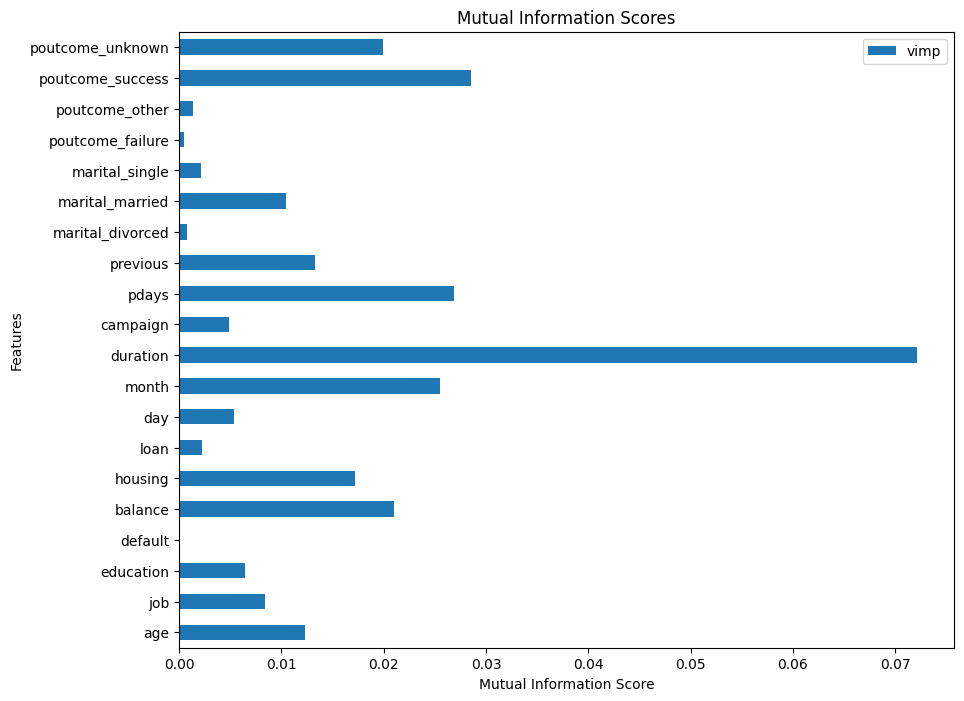

In [505]:
# Separate features and target
X = df_encoded.drop('y', axis=1)
y = df_encoded['y']

# Calculate Mutual Information
mic = feature_selection.mutual_info_classif(X, y)

# Create a DataFrame for the visualization
mi_df = pd.DataFrame({"feature": X.columns, "vimp": mic}).set_index("feature")

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
mi_df.plot.barh(ax=ax)
plt.title('Mutual Information Scores')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.show()

<div style="background-color: yellow; color: black; padding: 10px;">
    duration highly affects the output. e.g., if duration=0 then y='no'
</div>

## Lasso Regression
Using lasso regression, we can set an alpha parameter that acts as a regularization parameter. \
As we increase the value, it gives less weight to features that are less important.

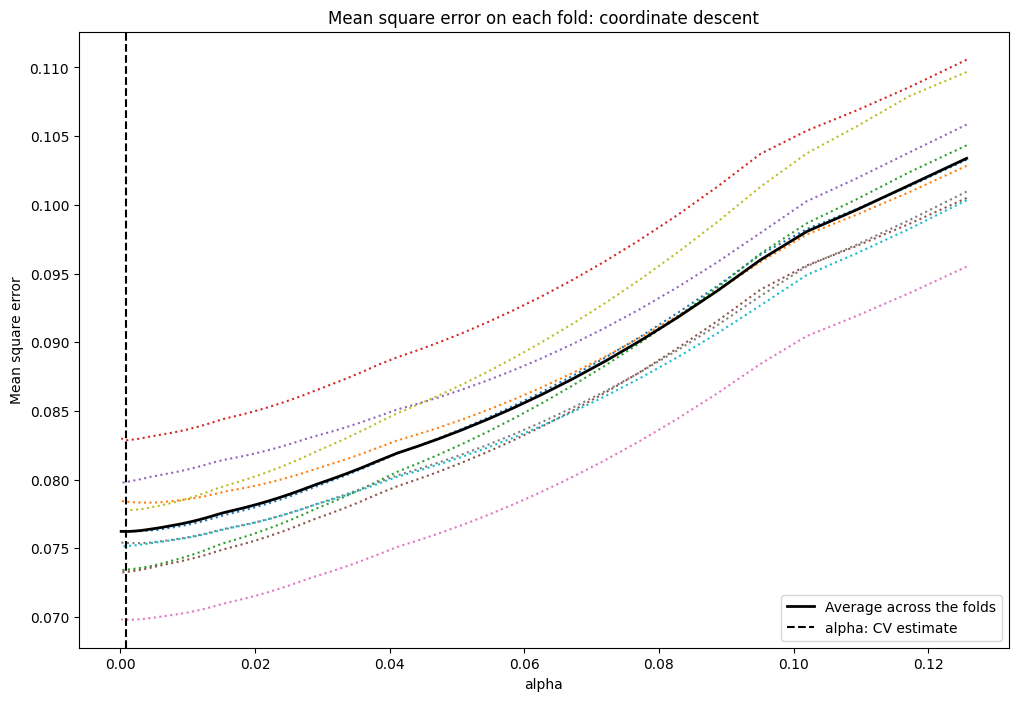

In [506]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert the scaled array back into a DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Separate the target variable
y = df['y'].values

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and fit the LassoCV model
lasso = LassoCV(cv=10, random_state=42, max_iter=10000).fit(X_train, y_train)

# Plot the coefficient progression
plt.figure(figsize=(12, 8))
plt.plot(lasso.alphas_, lasso.mse_path_, ':')
plt.plot(lasso.alphas_, lasso.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(lasso.alpha_, linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()
plt.xlabel('alpha')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent')
plt.axis('tight')
plt.show()

In [507]:
# Retrieve the coefficient of the features
coefficients = pd.Series(lasso.coef_, index=X.columns)

# Print out the coefficients
print(coefficients.sort_values())

housing            -0.035187
poutcome_unknown   -0.017735
loan               -0.010891
campaign           -0.005209
marital_married    -0.004665
default            -0.001151
day                -0.000781
month              -0.000267
poutcome_failure    0.000000
pdays               0.000000
marital_divorced    0.000000
job                 0.002697
previous            0.003434
balance             0.004576
poutcome_other      0.005118
age                 0.006614
marital_single      0.010419
education           0.010714
poutcome_success    0.080181
duration            0.121079
dtype: float64


<div style="background-color: yellow; color: black; padding: 10px;">
    A coefficient of 0 means that the feature is not contributing to the model at all. Lasso has removed it during the regularization process. For instance, poutcome_failure, pdays, and marital_divorced have zero coefficients, implying that they do not have any linear predictive value with the target variable in the presence of the other variables.
</div>

<div style="background-color: yellow; color: black; padding: 10px;">
    The larger the absolute value of the coefficient, the more significant the feature's impact on the target variable. duration has the highest positive coefficient (0.121079), signifying it has the most substantial positive effect on the target variable among all the features.
</div>

## Tree-based Feature Selection

In [508]:
# Define the classifier and fit to the data
clf = ExtraTreesClassifier(n_estimators=50, random_state=42)
clf = clf.fit(X, y)

# Print the feature importances
print("Feature Importances:", clf.feature_importances_)

# Use SelectFromModel to select features based on importance weights
model = SelectFromModel(clf, prefit=True)

# Transform the dataset to the selected features
X_new = model.transform(X)

# The shape of X_new will tell you how many features are selected
print("Original number of features:", X.shape[1])
print("Reduced number of features:", X_new.shape[1])

Feature Importances: [0.10653111 0.05970833 0.02719001 0.00279345 0.10425708 0.02306046
 0.00909121 0.10022021 0.09316183 0.25402077 0.0628576  0.02913139
 0.01993722 0.00425923 0.00600799 0.00570575 0.00793775 0.00408642
 0.06627883 0.01376337]
Original number of features: 20
Reduced number of features: 8


In [509]:
# Get the feature importances
feature_importances = clf.feature_importances_

# Create a pandas series to view the feature importances with the feature names
feature_importances_series = pd.Series(feature_importances, index=X.columns)

# Output the feature importance scores for each feature
print("Feature Importance Scores:")
print(feature_importances_series.sort_values(ascending=False))

Feature Importance Scores:
duration            0.254021
age                 0.106531
balance             0.104257
day                 0.100220
month               0.093162
poutcome_success    0.066279
campaign            0.062858
job                 0.059708
pdays               0.029131
education           0.027190
housing             0.023060
previous            0.019937
poutcome_unknown    0.013763
loan                0.009091
poutcome_failure    0.007938
marital_married     0.006008
marital_single      0.005706
marital_divorced    0.004259
poutcome_other      0.004086
default             0.002793
dtype: float64


Higher scores indicate greater importance. The sum of all scores typically equals 1.0, with each score representing the proportion of predictive information the feature contributes to the model.

<div style="background-color: yellow; color: black; padding: 10px;">
    Least Important Features (default, marital_divorced, poutcome_other, etc.): With importance scores near 0.002 to 0.004, these features are the least influential according to the model and may be candidates for removal in feature selection processes.
</div>

## Feature Importance (AKA Model-based feature selection)
In SKLearn, SelectFromModel is a meta-transformer that can be used along with any model that importance of each feature through a specific attribute (such as coef_, feature_importances_) or callable after fitting.

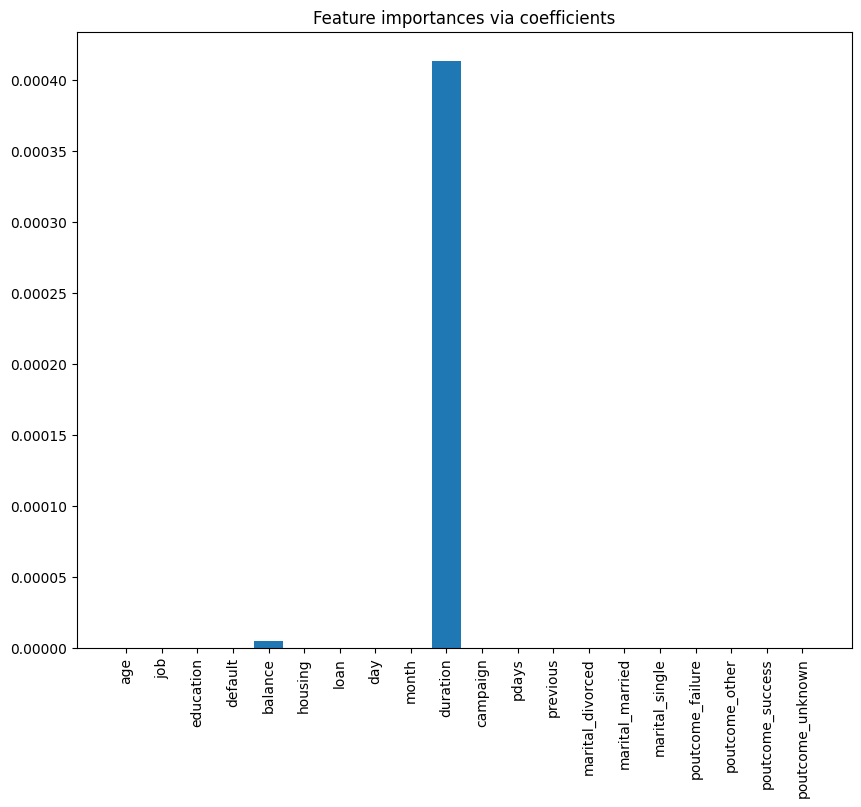

Features selected by SelectFromModel:  []
Done in 0.477s


In [510]:
X = df_encoded.drop('y', axis=1)  # df_encoded should be the DataFrame after encoding and excluding the target
y = df_encoded['y']

# Fit LassoCV to the data
lasso = LassoCV(cv=5).fit(X, y)

# Calculate the absolute values of the coefficients
importance = np.abs(lasso.coef_)

# Assuming feature names are the column names of X
feature_names = np.array(X.columns)

# Plotting the feature importances
plt.figure(figsize=(10, 8))  # Adjusting figure size for better readability
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.xticks(rotation=90)  # Rotating feature names for better visibility
plt.show()

# Setting the threshold for feature selection slightly above the third most important feature
threshold = np.sort(importance)[-3] + 0.01

# Timing the feature selection process
tic = time()
sfm = SelectFromModel(lasso, threshold=threshold).fit(X, y)
toc = time()

# Printing the selected features
print("Features selected by SelectFromModel: ", feature_names[sfm.get_support()])
print(f"Done in {toc - tic:.3f}s")

<div style="background-color: yellow; color: black; padding: 10px;">
    The feature duration has a significantly taller bar compared to the others. This indicates that duration has the largest absolute coefficient value and is likely the most important predictor in the Lasso model. And other features don't add much value in the presence of duration.
</div>

<div style="background-color: blue; color: white; padding: 10px;">
    Decision to remove duration.
</div>

In [511]:
df_encoded.drop('duration', axis=1, inplace=True)
df.drop('duration', axis=1, inplace=True)

# Dimensionality Reduction
Dimensionality Reduction techniques decompose features into a smaller subset, this can be useful for exploratory data analysis, visualization, making predictive modelling and clustering.

## Principal Component Analysis (PCA)

## Uniform Manifold Approximation and Projection (UMAP)

## Potential of Heat-diffusion for Affinity-based Trajectory Embedding (PHATE)

# Feature Engineering
The process of using domain knowledge to create features or input variables that help ML algorithms perform better.

## Feature Scaling: Standardization

In [512]:
df_standardized = df_encoded.copy()

### pdays: Treat -1 as Missing and Standardize the Rest

In [513]:
# Replace -1 with NaN for standardization purposes
df_standardized['pdays_clean'] = df_standardized['pdays'].replace(-1, np.nan)

# Initialize the scaler
scaler = StandardScaler()

# Fit scaler on non-NaN data
scaler.fit(df_standardized['pdays_clean'].dropna().values.reshape(-1, 1))

# Apply transformation to the non-NaN data
df_standardized['pdays_standardized'] = scaler.transform(df_standardized['pdays_clean'].values.reshape(-1, 1))

# Replace NaNs back to -1 after standardization
df_standardized['pdays_standardized'] = df_standardized['pdays_standardized'].fillna(-1)

df_standardized.head()

,age,job,education,default,balance,housing,loan,day,month,campaign,...,y,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,pdays_clean,pdays_standardized
0,58,4,3,0,2143,1,0,5,8,1,...,0,0,1,False,False,False,0,True,NaN,-1.0
1,44,9,2,0,29,1,0,5,8,1,...,0,0,0,True,False,False,0,True,NaN,-1.0
2,33,2,2,0,2,1,1,5,8,1,...,0,0,1,False,False,False,0,True,NaN,-1.0
3,47,1,2,0,1506,1,0,5,8,1,...,0,0,1,False,False,False,0,True,NaN,-1.0
4,33,0,2,0,1,0,0,5,8,1,...,0,0,0,True,False,False,0,True,NaN,-1.0


### Rest of the columns except for target 'y'

In [514]:
# List of columns to standardize, excluding 'pdays', 'pdays_clean', and 'y'
columns_to_scale = df_standardized.columns.difference(['pdays', 'pdays_clean', 'y'])

# Fit and apply scaler to selected columns
df_standardized[columns_to_scale] = scaler.fit_transform(df_standardized[columns_to_scale])

df_standardized.head()

,age,job,education,default,balance,housing,loan,day,month,campaign,...,y,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,pdays_clean,pdays_standardized
0,1.606972,-0.089933,1.314530,-0.135498,0.256388,0.893884,-0.436760,-1.298451,0.823878,-0.569337,...,0,-0.360802,0.813212,-0.628070,-0.348709,-0.205984,-0.185959,0.472551,NaN,-0.31692
1,0.288511,1.454486,-0.218693,-0.135498,-0.437894,0.893884,-0.436760,-1.298451,0.823878,-0.569337,...,0,-0.360802,-1.229692,1.592179,-0.348709,-0.205984,-0.185959,0.472551,NaN,-0.31692
2,-0.747424,-0.707701,-0.218693,-0.135498,-0.446762,0.893884,2.289585,-1.298451,0.823878,-0.569337,...,0,-0.360802,0.813212,-0.628070,-0.348709,-0.205984,-0.185959,0.472551,NaN,-0.31692
3,0.571038,-1.016585,-0.218693,-0.135498,0.047184,0.893884,-0.436760,-1.298451,0.823878,-0.569337,...,0,-0.360802,0.813212,-0.628070,-0.348709,-0.205984,-0.185959,0.472551,NaN,-0.31692
4,-0.747424,-1.325468,-0.218693,-0.135498,-0.447090,-1.118713,-0.436760,-1.298451,0.823878,-0.569337,...,0,-0.360802,-1.229692,1.592179,-0.348709,-0.205984,-0.185959,0.472551,NaN,-0.31692


## Polynomial Features

In [515]:
from sklearn.preprocessing import PolynomialFeatures

## Automated Feature Engineering

### Featuretools

In [516]:
import featuretools as ft

### autofeat

In [517]:
AutoFeatRegressor

NameError: name 'AutoFeatRegressor' is not defined

### tsfresh

In [ ]:
from tsfresh.examples.robot_execution_failures import (
    download_robot_execution_failures,
    load_robot_execution_failures,
    extract_relevant_features
)

ImportError: cannot import name 'extract_relevant_features' from 'tsfresh.examples.robot_execution_failures' (/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tsfresh/examples/robot_execution_failures.py)

## Data/Information Leakage analysis

## Unsupervised approaches

### Dimensionality reduction

### Clustering

## Semi-supervised approaches

### Self-Learning

### Clustering for Semi-Supervised Learning